**Part 2 - Carpet Detector**

Paulo Yoshio Kuga


Firstly, we shall import libraries that are needed in this notebook, and write the predefined classes:


In [ ]:
import pandas as pd
import os

from scipy import signal

import matplotlib.pyplot as plt

import numpy as np

from pydantic import BaseModel, Field
from typing import List

class CarpetRegion(BaseModel):
    start_hz: float = Field(..., description="Start frequency in Hz")
    end_hz: float = Field(..., description="End frequency in Hz")
class Wave(BaseModel):
    time: List[float] = Field(..., description="Time points of the wave")
    signal: List[float] = Field(..., description="Signal values")


1. Develop a model to detect the carpet regions that might be present in the signal. Requisites:

    a. The model must be implemented according to the following Python template. You must use the classes provided to represent the data.

    b. Valid carpets must be above 1000 Hz.

    c. There can be more than one disjoint carpet region in the same spectrum. Example: 1500 Hz to 1700 Hz and 3000 Hz to 5000 Hz.
    
    d. There cannot be overlapping carpet regions.

In [170]:
path = "./part_2/"
files = os.listdir(path)

data = pd.read_csv(path+files[10])

data

,t,data
0,0.000000,1.259804
1,0.000062,-2.145753
2,0.000124,-1.611859
3,0.000186,1.752575
4,0.000248,1.417988
...,...,...
32763,2.029926,3.135990
32764,2.029988,1.247544
32765,2.030050,-2.661571
32766,2.030112,-1.623278


Through data importing, it is possible to analyze a sample. Indeed, time can be plot as x-axis.

<Axes: xlabel='t'>

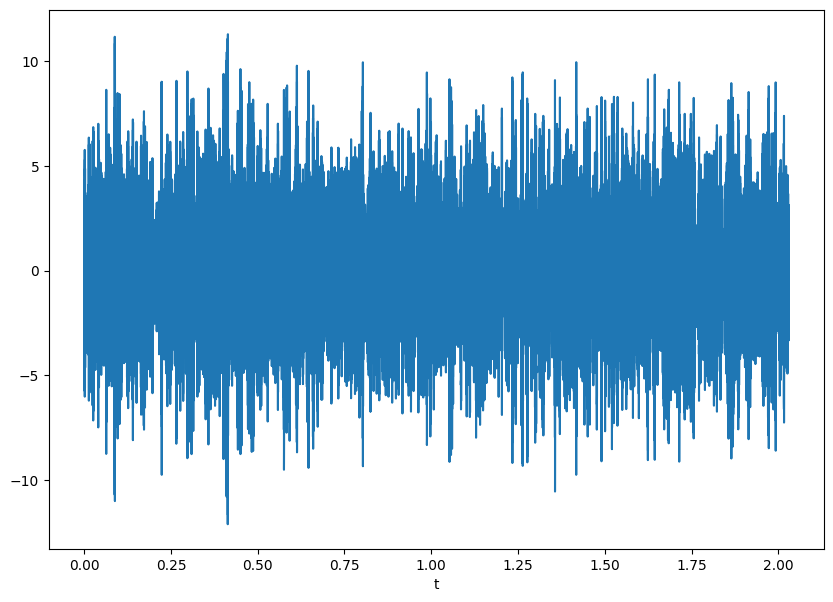

In [174]:
data.set_index("t")["data"].plot(figsize=(10,7))

Before proceeding, we can load all data into memory and check if all samples are consistently in relation to their sizes:

In [ ]:
dataDict = {file: pd.read_csv(path + file) for file in files}

data = dataDict[files[0]]
for file in dataDict:
    dataImported = dataDict[file]
    if(dataImported.shape != data.shape):
        print(file + "not consistent.")
    data = dataImported

Then, it is possible to analyze the signal into frequency. Using a Welch, it is possible to obtain its spectrum.

Text(0.5, 1.0, '11d8b435-ba4a-564f-b0e8-d5cbed8adbb2.csv')

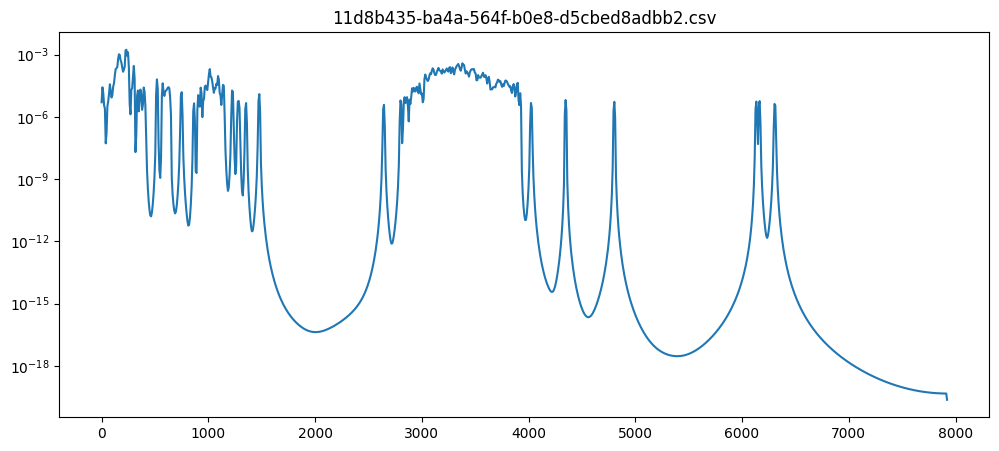

In [194]:
dataName = files[0]

data = dataDict[dataName]

fs = data.shape[0] / data["t"].max() #sample rate

#in this case, nperseg and overlap where choosen to be with a greater resolution, since we want to locate the carpet. flattop window was used, but did not showed the carpet. 
f, Pxx = signal.welch(data["data"].to_numpy(), fs=fs, window='hann', nperseg=2048, noverlap=1024, scaling='density')

Pxx = pd.Series(Pxx,index=f)

Pxx.plot(logy=True,figsize=(12,5))
plt.title(dataName)

What if the mean energy of the signal can be obtained through each point? A rolling window can be used to this.

Text(0.5, 1.0, '11d8b435-ba4a-564f-b0e8-d5cbed8adbb2.csv - rolling window')

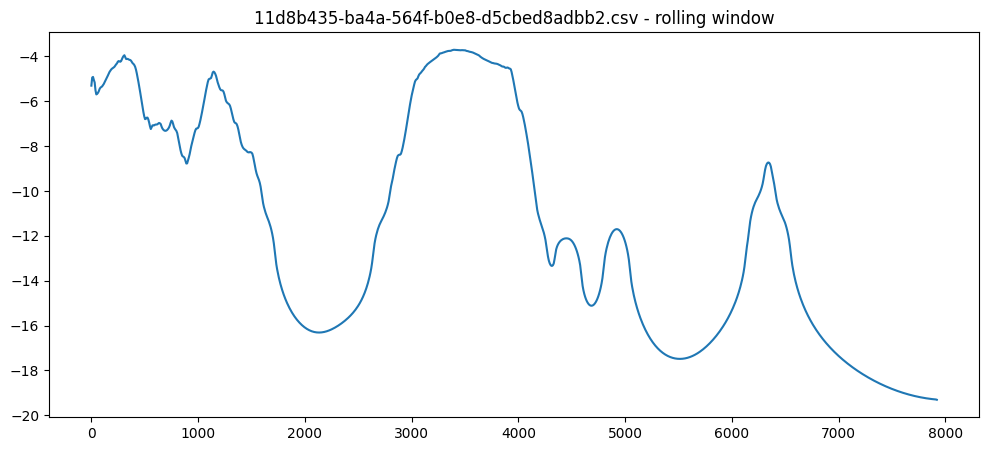

In [302]:
w = 32 #rolling window size

loggedSignal = Pxx.apply(np.log10)

smoothedW = loggedSignal.rolling(min_periods=1,window=w).mean()

smoothedW.plot(figsize=(12,5))
plt.title(dataName + " - rolling window")

Later, through testing, a reasonable logic of, when the signal is more than -5 units, it might be a carpet. However, not all signals have the same energy. Therefore, a second approach of obtaining the metrics of the peaks was developed. 

Determining the signals greater than the mean plus one standard deviation might be enough to determine if whether or not is a peak on the spectrum. After this calculation of these peaks, a standard deviation from peaks is subtracted, being a safety margin to the consideration. 

In [303]:
overPeaks = loggedSignal.loc[loggedSignal > (loggedSignal.mean() + loggedSignal.std())]

carpets = ((smoothedW > (loggedSignal.mean() + loggedSignal.std() - overPeaks.std()))*1)

In [304]:
ilocArg = int(np.ceil(1000/(fs/2048))) #frequency index where 1000 Hz is stored (delta f = fs/nperseg)

carpets.iloc[ilocArg] = int(not bool(carpets.iloc[ilocArg])) #into 1005, we invert the value to assure that carpets detected before 1000 that continues more than 1000 are going to be counted

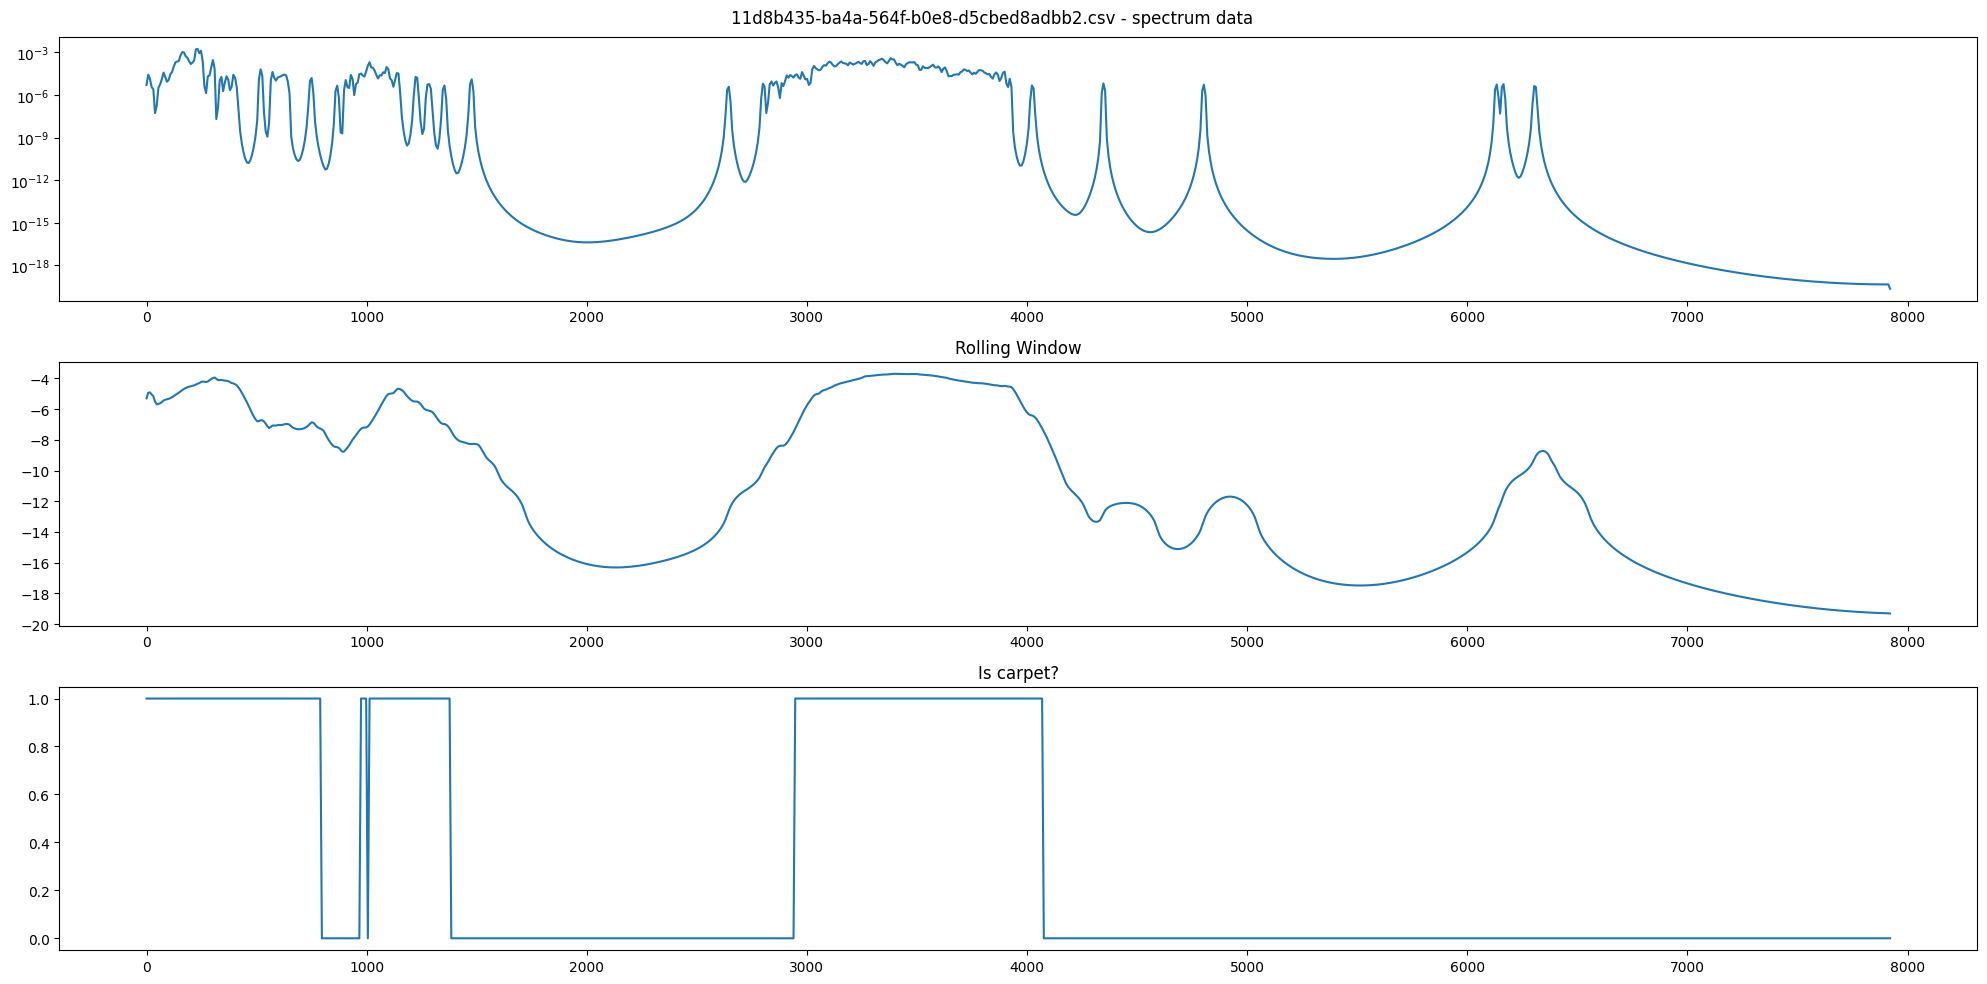

In [305]:
fig,axs = plt.subplots(3,1,figsize=(20,10))


axs[0].semilogy(f,Pxx)
smoothedW.plot(ax=axs[1],title="Rolling Window")
carpets.plot(ax=axs[2],title="Is carpet?")

fig.suptitle(dataName + " - spectrum data")
plt.tight_layout()

Then, a rule of detecting the rectangles associated to the carpets is developed, doing a shift into the carpet boolean. Nonetheless, valid carpets are over 1000 Hz. 

In [306]:
validCarpetsIntervals = carpets.loc[
    ((carpets != carpets.shift(-1)) == True) &
    (carpets.index > 1000)
    ].index

validCarpetsIntervals

Index([1005.5629139072846,  1376.847682119205, 2939.3377483443705,
       4068.6622516556286,  7920.741721854303],
      dtype='float64')

Then, it is possible to return a list of the valid carpets. However, it is noticeable that some peaks might be understand as a carpet, due to the proximity of other peaks or even the carpet, leading the mean energy to be higher than the threshold. Therefore, it is possible to set an another threshold, in this case, it is set as 150.

In [307]:
[CarpetRegion(start_hz=validCarpetsIntervals[i-1],end_hz=validCarpetsIntervals[i]) for i in range(1,len(validCarpetsIntervals),2) if validCarpetsIntervals[i]-validCarpetsIntervals[i-1] > 150]
    

[CarpetRegion(start_hz=1005.5629139072846, end_hz=1376.847682119205),
 CarpetRegion(start_hz=2939.3377483443705, end_hz=4068.6622516556286)]

Hard code isn't adequate. Therefore, we can use ''params'' in the model to assure that all parameters are set.

Later, for item 2, it is implemented the plotCarpets function into the model class and score is implemented for item 3. 

In [321]:
class Model:
    def __init__(self, **params):
        # Store hyperparameters if needed
        defaultParams = {"threshold_CarpetFrequency":1000,
                         "threshold_PeakFrequency":150,
                         "window":"hann",
                         "nperseg":2048,
                         "noverlap":1024,
                         "rolling_window_size":32
                         }
    
        self.params = {**defaultParams, **params}

    def predict(self, wave: Wave) -> List[CarpetRegion]:
        """
        Predict carpet regions from a given wave.
        This should be implemented with actual logic.
        """

        waveSignal = np.array(wave.signal)


        fs = waveSignal.shape[0] / max(wave.time) #sample rate
        f, Pxx = signal.welch(waveSignal, fs=fs, window=self.params["window"], nperseg=self.params["nperseg"], noverlap=self.params["noverlap"])
        Pxx = pd.Series(Pxx,index=f)
        
        loggedSignal = Pxx.apply(np.log10)

        smoothedW = loggedSignal.rolling(min_periods=1,window=self.params["rolling_window_size"]).mean()

        overPeaks = loggedSignal.loc[loggedSignal > loggedSignal.mean() + loggedSignal.std()]

        carpets = ((smoothedW > (loggedSignal.mean() + loggedSignal.std() - overPeaks.std()))*1)

        ilocArg = int(np.ceil(self.params["threshold_CarpetFrequency"]/(fs/self.params["nperseg"]))) #frequency index where 1000 Hz is stored (delta f = fs/nperseg)

        carpets.iloc[ilocArg] = int(not bool(carpets.iloc[ilocArg])) #into 1005, we invert the value to assure that carpets detected before 1000 that continues more than 1000 are going to be counted

        self.whereIsCarpet = ((carpets != carpets.shift(-1)) == True) & (carpets.index > self.params["threshold_CarpetFrequency"])

        self.whereIsCarpetFull = (carpets== True) & (carpets.index > self.params["threshold_CarpetFrequency"])


        validCarpetsIntervals = carpets.loc[self.whereIsCarpet].index

        self.selectedCarpets =  [CarpetRegion(start_hz=validCarpetsIntervals[i-1],end_hz=validCarpetsIntervals[i]) for i in range(1,len(validCarpetsIntervals),2) if validCarpetsIntervals[i]-validCarpetsIntervals[i-1] > self.params["threshold_PeakFrequency"]]

        return self.selectedCarpets
    

    
    def score(self) -> list[float]:
        self.Metric = [carpet.end_hz-carpet.start_hz for carpet in self.selectedCarpets]
        return self.Metric
    
    def plotCarpets(self,f,loggedSignal,figsize=(20,10)):

        fig,axs = plt.subplots(1,1,figsize=figsize)

        loggedSignal.plot(ax=axs)

        ymin, ymax = axs.get_ylim()

        axs.fill_between(f,ymin, ymax, 
                            where=self.whereIsCarpetFull, 
                            color="red", 
                            alpha=0.3, 
                            label="Carpet Region" 
                            )

        return fig,axs




2. Detect carpets on all the signals provided and plot each spectrum with the corresponding identified region.

 



In [312]:
waveProvided = Wave(time=data["t"],signal=data["data"])

carpetModel = Model()

carpetModel.predict(wave=waveProvided)

[CarpetRegion(start_hz=1005.5629139072846, end_hz=1376.847682119205),
 CarpetRegion(start_hz=2939.3377483443705, end_hz=4068.6622516556286)]

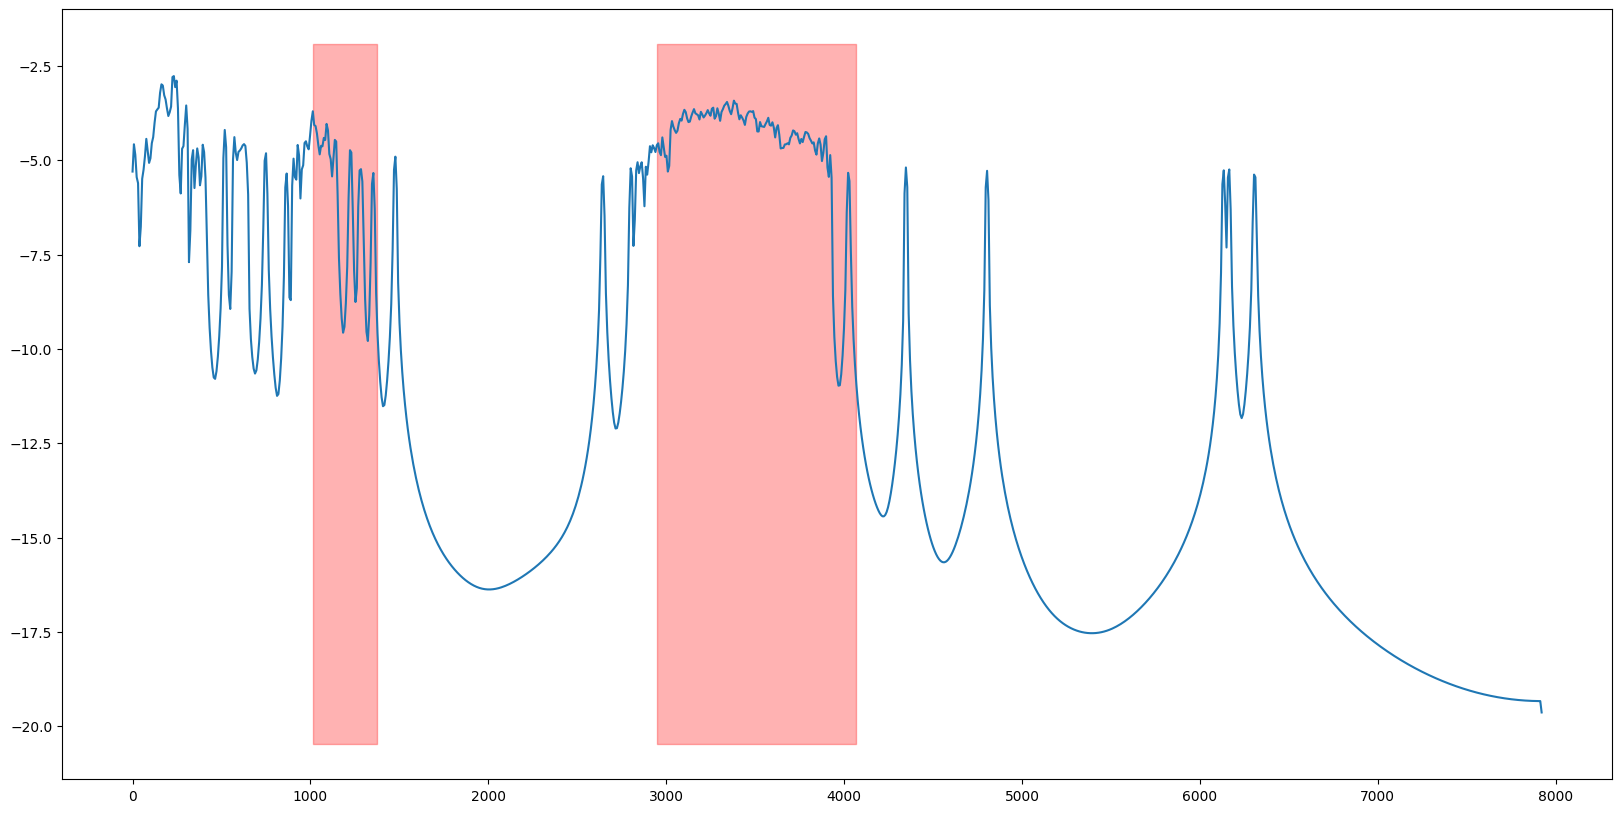

In [320]:
carpetModel.plotCarpets(f,loggedSignal)

3. Using the results, propose a metric to quantify the carpet severity and find the sample with the worst carpet symptom

In [322]:
carpetModel.score()

[371.28476821192044, 1129.324503311258]